## 导入

In [2]:
import pandas as pd
# 设置pandas显示所有列
pd.set_option('display.max_columns', None)
# 设置pandas显示所有行
pd.set_option('display.max_rows', None)
import numpy as np
random_state = 2023

csv4 = r'H:\data\data.csv'

data = pd.read_csv(csv4)
data =data.drop(columns = ["na","k","cl","ca","p"])
# 指定变量类型
category_features = ['uremia','dvt','fatty_liver','diabetes','hypertension','coronary_disease','atrial_fibrillation','hyperuricemia','hyperlipidaemia','hypoproteinemia','cerebral_hernia','hydrocephalus',
'frontal_lobe','parietal_lobe','temporal_lobe','occipital_lobe','insular_lobe','range_lobe','basal_ganglia','brainstem','epencephalon','paraventricular','centrum_semiovale','thalamus',
'aca','mca','pca','va','ba',
'gender',
'cca_plaque','ica_plaque','eca_plaque','subcortex_lobe']  # 'capsula_interna',

continous_features = ['age','plt','wbc','rbc','hba1c','crp','tg','ldl','hdl','ast','alt','bilirubin','albumin','urea','creatinine','bua','pt','aptt','tt','inr','d_dimer','fibrinogen','ck','ldh','hbdh','ima','lactate','anion_gap','tco2','nihss'] # 'na','k','cl','ca','p', # 'ck_mb',

LABEL = ['second_epilepsy']

# category_data = data[category_features]
# continous_data = data[continous_features]
# print(sum(np.array(data[LABEL[0]].tolist())))
# sum(np.array(data[LABEL[0]].tolist())) / data.shape[0]

## 数据处理

In [3]:
## 划分数据集
from sklearn.model_selection import train_test_split
Train_data, Test_data, Train_label, Test_label = train_test_split(
    data.drop(columns = LABEL),
    data[LABEL[0]],
    test_size = 0.2,
    random_state = random_state)
Train_data_category = Train_data[category_features]
Test_data_category = Test_data[category_features]
Train_data_continous = Train_data[continous_features]
Test_data_continous = Test_data[continous_features]

print(Train_data.shape[0])
print(Test_data.shape[0])

17394
4349


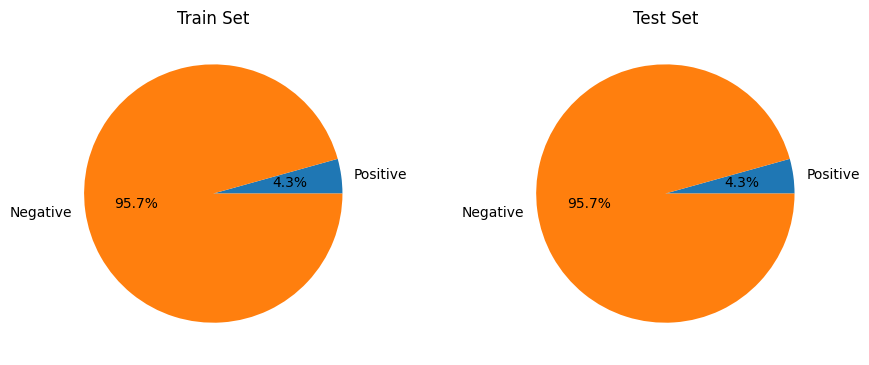

In [4]:
# 阳性比例
import matplotlib.pyplot as plt
# 训练集阳性患者比例
train_positive = sum(np.array(Train_label.tolist())) / Train_label.shape[0]
train_negative = 1 - train_positive
# 测试集阳性患者比例
test_positive = sum(np.array(Train_label.tolist())) / Train_label.shape[0]
test_negative = 1 - test_positive
# 创建一个包含两个子图的图表对象
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10,6))
# 绘制训练集饼状图
ax1.pie([train_positive, train_negative], labels=['Positive', 'Negative'], autopct='%1.1f%%')
ax1.set_title('Train Set')
# 绘制测试集饼状图
ax2.pie([test_positive, test_negative], labels=['Positive', 'Negative'], autopct='%1.1f%%')
ax2.set_title('Test Set')
# 调整子图之间的间距
plt.subplots_adjust(wspace=0.4)
# 显示图表
plt.show()



In [5]:
# 分类变量独热化
def Auto_OneHot(data_categorical,drop_first = False,nankeep = False):
    dummys = []
    data_categorical_dummied = data_categorical.copy(deep = True)
    for feature in data_categorical.columns:
        dummys.append(pd.get_dummies(data_categorical_dummied[feature], prefix = feature,drop_first=drop_first))
    for dummy in dummys:
        data_categorical_dummied = pd.concat([data_categorical_dummied,dummy], axis = 1)
    data_categorical_dummied = data_categorical_dummied.drop(columns = data_categorical.columns)
    #独热处理完毕
    if nankeep == True:
        for feature in data_categorical.columns:
            missing_feature = [col for col in data_categorical_dummied.columns if col.startswith(feature) and data_categorical[feature].isnull().any()]
            data_categorical_dummied.loc[data_categorical[feature].isnull(), missing_feature] = np.nan
    return(data_categorical_dummied)
Train_data_category_onehoted = Auto_OneHot(Train_data_category,drop_first = True)
Test_data_category_onehoted = Auto_OneHot(Test_data_category,drop_first = True)


In [6]:
# 连续数据标准化
from sklearn.preprocessing import StandardScaler
import pickle
def standardize_dataframe(df):
    scaler = StandardScaler()
    standardized_data = scaler.fit_transform(df)
    standardized_df = pd.DataFrame(standardized_data, columns=df.columns)

    # 保存标准化模型
    # joblib.dump(scaler, model_path)
    with open('standardize_model.pkl', 'wb') as f:
        pickle.dump(scaler, f)
        
    return standardized_df
def Standscaler_pack(data,mode = 'Train', standardscaler = ''):
    from sklearn.preprocessing import StandardScaler
    index_save = data.index.tolist()
    columns_save = data.columns.tolist()
    if mode == "Train":
        standardscaler = StandardScaler()
        data_scd = standardscaler.fit_transform(data)
        data_scd = pd.DataFrame(data_scd,index = index_save, columns = columns_save)
        return(data_scd, standardscaler)
    if mode == "Test":
        standardscaler = standardscaler
        data_scd = standardscaler.transform(data)
        data_scd = pd.DataFrame(data_scd,index = index_save, columns = columns_save)
        return(data_scd, standardscaler)

Train_data_continous_scd,standscaler0 = Standscaler_pack(Train_data_continous,mode = 'Train')
Test_data_continous_scd,_= Standscaler_pack(Test_data_continous,mode = 'Test',standardscaler = standscaler0)

# Train_data_continous_scd
# Test_data_continous_scd

In [7]:
Train_all = pd.concat([Train_data_category_onehoted,Train_data_continous_scd],axis = 1)
Test_all = pd.concat([Test_data_category_onehoted,Test_data_continous_scd],axis = 1)
# Train_all.to_csv('train.csv')
# Test_all.to_csv('test.csv')


### SMOTE

In [8]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(sampling_strategy={1: Train_label.sum() * 5}, random_state = random_state)
Train_all_SOMTED, Train_label_SOMTED = smote.fit_resample(Train_all, Train_label)

sum(np.array(Train_label_SOMTED.tolist())) / Train_label_SOMTED.shape[0]
# SMOTE完毕后阳性比例

0.18450455748309322

## 单因素显著分析T/U/Chi

In [9]:
# 数据描述
from scipy import stats
# 单因素显著性分析
from numpy import float64
from scipy.stats import shapiro#Shapiro-Wilk正态性检验
from scipy.stats import mannwhitneyu#Mann-Whitney检验比较非正态两组独立样本
import scipy.stats as stats#卡方分析
from scipy.stats import levene, ttest_ind

# 单因素分析
def Significance_test_for_continuous_variables(data_continuous,data_label,label):

    feature_name = []
    test_method = []
    pval = []
    stats_values = []
    data_continuous_filled = data_continuous
    #全部数据转为float64
    data_continuous_filled = data_continuous_filled.astype(float)

    #1.先用Shapiro-Wilk检验正态性
    Shapiro_Wilk_YES = []
    Shapiro_Wilk_NO = []

    for feature in data_continuous_filled.columns:
        stat ,p = shapiro(data_continuous_filled[feature])
        alpha = 0.05
        if p > alpha:
            Shapiro_Wilk_YES.append(feature)
        else:
            Shapiro_Wilk_NO.append(feature)
    print('▷Shapiro_Wilk检验:')
    print('     正态分布变量:',Shapiro_Wilk_YES)
    print('     非正态分布变量:',Shapiro_Wilk_NO)
    #print('\n')

    #为连续数据集添加label以便进行分组
    data_continuous_filled_withlabel = pd.concat([data_label,data_continuous_filled],axis = 1)
    #data_continuous_filled_withlabel
    #将两组样本分别取出
    data_continuous_filled_0 = data_continuous_filled_withlabel.loc[data_continuous_filled_withlabel[label] == 0]
    data_continuous_filled_1 = data_continuous_filled_withlabel.loc[data_continuous_filled_withlabel[label] == 1]


    #2.不满足正态分布的变量使用Mann-Whitney检验比较两组独立样本
    #Mann-Whitney U检验
    print('▷Mann-Whitney U检验:')
    for feature in Shapiro_Wilk_NO:
        stat, p = mannwhitneyu(data_continuous_filled_0[feature], data_continuous_filled_1[feature])
        alpha = 0.05
        if p > alpha:
            print('     ',feature,"两组独立样本中位数没有显著性差异。",p,stat)
        else:
            print('     ',feature,"两组独立样本中位数【有】显著性差异。",p,stat)
        feature_name.append(feature)
        test_method.append('Mann-Whitney U')
        pval.append(p)
        stats_values.append(stat)
    #print('\n')
    #满足正态分布的变量再检验其方差齐性
    Levene_YES = []
    Levene_NO = []
    for feature in Shapiro_Wilk_YES:
        if levene(data_continuous_filled_0[feature],data_continuous_filled_1[feature])[1] > 0.05:#p>0.05,方差齐
            Levene_YES.append(feature)
        else:
            Levene_NO.append(feature)
    #print('Levene检验：')
    #print('方差齐次:',Levene_YES)  
    #print('方差不齐:',Levene_NO)
    #print('\n')

    #方差齐的使用Student-T检验
    print('▷Student-T检验（方差齐）:')
    if Levene_YES != []:
        for feature in Levene_YES:
            stat,ttest_p = ttest_ind(data_continuous_filled_0[feature],data_continuous_filled_1[feature])
            if ttest_p < 0.05:
                print('     ',feature,'【有】显著性差异，p=',ttest_p,stat)
            else:
                print('     ',feature,'没有显著性差异，p=',ttest_p,stat)
            feature_name.append(feature)
            test_method.append('Student-T')
            pval.append(ttest_p)
            stats_values.append(stat)
    #print('\n')

    #方差不齐的使用Welch-T检验
    print('▷Welch-T检验（方差不齐）:')
    if Levene_NO != []:
        for feature in Levene_NO:
        #for feature in Shapiro_Wilk_NO:
            stat,ttest_p = ttest_ind(data_continuous_filled_0[feature],data_continuous_filled_1[feature],equal_var = False)
            if ttest_p < 0.05:
                print('     ',feature,'【有】显著性差异，p=',ttest_p,stat)
            else:
                print('     ',feature,'没有显著性差异，p=',ttest_p,stat)
            feature_name.append(feature)
            test_method.append('Welch-T')
            pval.append(ttest_p)
            stats_values.append(stat)

    return(feature_name,test_method,pval,data_continuous_filled,stats_values)
def Significance_test_for_categorical_variables(data_categorical,data_label,label,blank):
    feature_name = []
    test_method = []
    pval = []
    stats_values = []
    data_categorical_withlabel = pd.concat([data_label,data_categorical],axis = 1)
    data_categorical_withlabel.head(3)
    print('\nChi-Square检验：')
    for column in data_categorical:
        #a = pd.crosstab(index=data_categorical_withlabel[label], columns=data_categorical_withlabel[column])
        cross = pd.crosstab(data_categorical_withlabel[column],data_categorical_withlabel[label])
        stat, p, dof, expected = stats.chi2_contingency(cross)
        alpha = 0.05
        if p > alpha:
            #print(column,"不拒绝原假设，两个分类变量之间没有显著性差异。p =",p)
            print('     ',column,"，没有显著性差异。p =",p,stat)
        else:
            #print(column,"不拒绝原假设，两个分类变量之间没有显著性差异。p =",p)
            print('     ',column,"【有】显著性差异。p =",p,stat)
        feature_name.append(column)
        test_method.append('Chi-Square')
        pval.append(p)
        stats_values.append(stat)
    return(feature_name,test_method,pval,data_categorical,stats_values)
def ANA(TARGET,DATA,category_clinical_columns,continous_clinical_columns,LABEL):
    col = []
    all_clinical_processed = DATA.drop(columns = LABEL)
    for fea in list([set(category_clinical_columns) & set(all_clinical_processed.columns.tolist())][0]):
        sub_values = DATA[fea].tolist()
        temp = sorted(sub_values)
        temp = sorted(list(set(temp)))
        col.append('-')
        for sub_value in temp:
            count = (TARGET[fea]==sub_value).sum()
            col.append(str(count) + ' (' + str(round(100*count/TARGET.shape[0],3)) +'%)')
    for fea in list(set(continous_clinical_columns)&set(all_clinical_processed.columns.tolist())):
        # print(fea)
        list_arr = TARGET[fea].tolist()
        list_std = stats.tstd(list_arr)
        list_sem = stats.sem(list_arr)
        CI = stats.t.interval(0.95,df = len(list_arr)-1, loc = np.mean(list_arr),scale = list_sem)
        mean = np.mean(list_arr)
        # print(list_arr)
        sd = np.std(list_arr)
        mean_SD = str(round(mean,3)) + ' ± '+str(round(sd,3))
        col.append(mean_SD)
    return(col)
def CALCULATE(continous_data,category_data,label_df,LABEL,RESULT):
    feature_name,test_method,pval,_,stats_values = Significance_test_for_continuous_variables(
         continous_data,#all_clinical_processed_with_label[continous_clinical_columns_dropped],
         label_df,#all_clinical_processed_with_label['label'],
         LABEL#'label'
    )
    Significance_test_reportA = pd.DataFrame()
    Significance_test_reportA['feature_name'] = feature_name
    Significance_test_reportA['test_method'] = test_method
    Significance_test_reportA['pval'] = pval
    Significance_test_reportA['Stats_value'] = stats_values
    # Significance_test_reportA

    feature_name,test_method,pval,_,stats_values = Significance_test_for_categorical_variables(
         category_data,#all_clinical_processed_with_label[category_clinical_columns_dropped],
         label_df,#all_clinical_processed_with_label['label'],
         LABEL,#'label',
        '-'
    )
    Significance_test_reportB = pd.DataFrame()
    Significance_test_reportB['feature_name'] = feature_name
    Significance_test_reportB['test_method'] = test_method
    Significance_test_reportB['pval'] = pval
    Significance_test_reportB['Stats_value'] = stats_values
    # Significance_test_reportB

    Significance_test_report = pd.concat([Significance_test_reportA,Significance_test_reportB],axis = 0)
    # Significance_test_report

    methods = []
    ps = []
    Stat_values = []
    for item in RESULT['Feature'].tolist():
        if '——' not in item:
            # print(item)
            temp = Significance_test_report[Significance_test_report['feature_name'] == item]
            methods.append(temp['test_method'].tolist()[0])
            ps.append(temp['pval'].tolist()[0])
            Stat_values.append(temp['Stats_value'].tolist()[0])
        else:
            methods.append('-')
            ps.append('-')
            Stat_values.append('-')
    RESULT['method'] = methods
    RESULT['P'] = ps
    RESULT['stats'] = Stat_values 
    return(RESULT)
def REPORT(DATA,continous_clinical_columns,category_clinical_columns,LABEL):

    index = []
    all_clinical_processed = DATA.drop(columns = [LABEL])# .columns.tolist()
    for fea in list([set(category_clinical_columns) & set(DATA.drop(columns = LABEL).columns.tolist())][0]):
        index.append(fea)
        sub_values = [ '——' + str(x) for x in all_clinical_processed[fea].tolist()]
        temp = sorted(sub_values)
        temp = sorted(list(set(temp)))
        index = index + temp
    index = index + list(set(continous_clinical_columns)&set(DATA.drop(columns = LABEL).columns.tolist()))


    result = pd.DataFrame()
    pos = DATA[DATA[LABEL] == 1]
    neg = DATA[DATA[LABEL] == 0]
    pos_counts = pos.shape[0]
    neg_counts = neg.shape[0]
    result['Feature'] = index
    result['positive, N=' + str(pos_counts)] =ANA(pos,DATA,category_clinical_columns,continous_clinical_columns,LABEL)
    result['negative, N = ' + str(neg_counts)] =ANA(neg,DATA,category_clinical_columns,continous_clinical_columns,LABEL)

    RESULT = CALCULATE(
        DATA[continous_clinical_columns],
        DATA[category_clinical_columns],
        DATA[LABEL],
        LABEL,
        result)
    return(RESULT)

# Train_clinical_processed_with_label = data[[LABEL] + category_features + continous_features]

report_UTChi = REPORT(
    data,
    continous_features,
    category_features,
    LABEL[0])


C:\Users\Shinelon\AppData\Roaming\Python\Python39\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


▷Shapiro_Wilk检验:
     正态分布变量: []
     非正态分布变量: ['age', 'plt', 'wbc', 'rbc', 'hba1c', 'crp', 'tg', 'ldl', 'hdl', 'ast', 'alt', 'bilirubin', 'albumin', 'urea', 'creatinine', 'bua', 'pt', 'aptt', 'tt', 'inr', 'd_dimer', 'fibrinogen', 'ck', 'ldh', 'hbdh', 'ima', 'lactate', 'anion_gap', 'tco2', 'nihss']
▷Mann-Whitney U检验:
      age 两组独立样本中位数【有】显著性差异。 0.013187641008043056 10386092.0
      plt 两组独立样本中位数【有】显著性差异。 7.037901250688083e-24 11826502.5
      wbc 两组独立样本中位数【有】显著性差异。 0.0 2667973.0
      rbc 两组独立样本中位数【有】显著性差异。 6.07309833282999e-29 7811417.0
      hba1c 两组独立样本中位数【有】显著性差异。 3.482708033160417e-05 9132523.0
      crp 两组独立样本中位数【有】显著性差异。 2.0284719412259884e-286 3060302.0
      tg 两组独立样本中位数【有】显著性差异。 4.2922191168332e-35 7582690.5
      ldl 两组独立样本中位数没有显著性差异。 0.23394007452782428 10140916.5
      hdl 两组独立样本中位数没有显著性差异。 0.6195018798058995 10008026.0
      ast 两组独立样本中位数【有】显著性差异。 2.710371708970817e-227 3814876.0
      alt 两组独立样本中位数【有】显著性差异。 1.9593686364057413e-33 7632233.5
      bilirubin 两组独立样本中位数【有】显著

In [10]:
# 单因素显著性分析报告
# 对report_UTChi进行汉化
# CNdataaframe = pd.read_excel(r'D:\_CT_\分析\data\feature_names_CN.xlsx')

# CNfeatures = []
# for item in report_UTChi['Feature'].tolist():
#     if item in CNdataaframe['name'].tolist():
#         CN_feature = CNdataaframe[CNdataaframe['name'] == item]['特征名'].values[0]
#         # display(CN_feature)
#         CNfeatures.append(CN_feature)
#     else:
#         CNfeatures.append(item)
# report_UTChi['Feature'] = CNfeatures
report_UTChi



,Feature,"positive, N=954","negative, N = 20789",method,P,stats
0,eca_plaque,-,-,Chi-Square,0.438971,0.59897
1,——0,942 (98.742%),20591 (99.048%),-,-,-
2,——1,12 (1.258%),198 (0.952%),-,-,-
3,subcortex_lobe,-,-,Chi-Square,0.001273,10.381551
4,——0,814 (85.325%),18454 (88.768%),-,-,-
5,——1,140 (14.675%),2335 (11.232%),-,-,-
6,ba,-,-,Chi-Square,0.991017,0.000127
7,——0,945 (99.057%),20605 (99.115%),-,-,-
8,——1,9 (0.943%),184 (0.885%),-,-,-
9,hypertension,-,-,Chi-Square,0.602539,0.271184


## 单因素逻辑回归

In [11]:
# 单+多因素分析
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import logit
def mean_SD(LIST):
    list_arr = LIST
    list_std = stats.tstd(list_arr)
    list_sem = stats.sem(list_arr)
    CI = stats.t.interval(0.95,df = len(list_arr)-1, loc = np.mean(list_arr),scale = list_sem)
    mean = np.mean(list_arr)
    sd = np.std(list_arr)
    mean_SD = str(round(mean,3)) + ' ± '+str(round(sd,3))
    #col.append(mean_SD)
    return(mean_SD)    
def Percentage_describe(LIST,sub_value):
    count = LIST.count(sub_value) 
    return(str(count) + ' (' + str(round(100*count/len(LIST),3)) +'%)')
# 单因素逻辑回归分析
def Univariable_Analysis_likeR(data_withlabel, continous_columns, category_columns, LABEL, WARNING = False):
    if WARNING == False: 
        import warnings
        warnings.filterwarnings("ignore")
    # 多个变量因子化
    for item in category_columns:
        data[item] = data[item].astype('category')
        
    result = pd.DataFrame()
    independent_vars = continous_columns + category_columns 
    for var in independent_vars:
        # print(var)
        formula = f'{LABEL} ~ {var}'
        model = logit(formula, data=data)
        fit = model.fit(disp=False)
        temp_result = pd.DataFrame(fit.summary().tables[1].data[1:], columns=fit.summary().tables[1].data[0])
        temp_row = pd.DataFrame()
        if var in continous_columns:
            positive_describe = mean_SD(data[data[LABEL]==1][var].tolist())
            negative_describe = mean_SD(data[data[LABEL]==0][var].tolist())
            OR = np.exp(float(temp_result.loc[1]['coef']))
            ORlower = np.exp(float(temp_result.loc[1]['[0.025']))
            ORupper = np.exp(float(temp_result.loc[1]['0.975]']))
            P = float(temp_result.loc[1]['P>|z|'])
            main = (str(round(OR,3)) +' (' + str(round(ORlower,3)) + '-' + str(round(ORupper,3))+', p=' + str(round(P,3)) + ')' )
            temp_row['Feature'] = [var]
            temp_row['0' + ' (N=' + str(len(data[data[LABEL]==0][var].tolist())) + ')'] = [negative_describe]
            temp_row['1' + ' (N=' + str(len(data[data[LABEL]==1][var].tolist())) + ')'] = [positive_describe]
            temp_row['OR (univariable)'] = [main]
            temp_row.index = [1]
            temp_row = pd.concat([temp_row,temp_result],axis = 1)
            temp_row = temp_row.drop(columns = [''])
            temp_row = temp_row.loc[1]
            temp_result_mod = pd.DataFrame([temp_row.to_dict()])

        if var in category_columns:
            # display(temp_result)
            temp_result_mod = pd.DataFrame()
            sub_values = sorted(list(set(sorted(data[var].tolist()))))
            features = []
            negative_describes = []
            positive_describes = []
            ORS = []
            for sub_value in sub_values:
                negative_describe = Percentage_describe(data[data[LABEL]==0][var].tolist(),sub_value)
                positive_describe = Percentage_describe(data[data[LABEL]==1][var].tolist(),sub_value)
                temp_result['OR (univariable)'] = temp_result.apply(lambda row: str(round(np.exp(float(row['coef'])),3)) +' (' + str(round(np.exp(float(row['[0.025'])),3)) + '-' + str(round(np.exp(float(row['0.975]'])),3)) +', p=' + str(round(float(row['P>|z|']),3)) + ')', axis = 1 )
                negative_describes.append(negative_describe)
                positive_describes.append(positive_describe)
                features.append(var + '_' + str(sub_value))
            temp_result_mod['Feature'] = features
            temp_result_mod['0' + ' (N=' + str(len(data[data[LABEL]==0][var].tolist())) + ')'] = negative_describes
            temp_result_mod['1' + ' (N=' + str(len(data[data[LABEL]==1][var].tolist())) + ')'] = positive_describes
            temp_result_mod = pd.concat([temp_result_mod,temp_result],axis = 1)

            column_name = 'OR (univariable)'
            column = temp_result_mod.pop(column_name)
            temp_result_mod.insert(3, column_name, column)
            temp_result_mod = temp_result_mod.drop(columns = '')

            # print('OK')
            temp_result_mod.iloc[0, 3:] = "-"
    #     display(temp_result_mod)
        result = pd.concat([result,temp_result_mod],axis = 0)
        # result.to_excel(r'H:\开题\图片\a.xls')
    return(result)

Univariable_Analysis_report = Univariable_Analysis_likeR(
    data, 
    continous_features, 
    category_features, 
    LABEL[0], 
    WARNING = False)

In [12]:
# 单因素逻辑回归报告
Univariable_Analysis_report
Univariable_Analysis_report.to_excel(r'H:\开题\图片\Univariable_Analysis.xls',index = False)

## 多因素逻辑回归

In [13]:
# 从单因素回归结果中筛选变量
temp = Univariable_Analysis_report[Univariable_Analysis_report['P>|z|'] != "-"]
temp["P>|z|"] = np.array(temp["P>|z|"].tolist()).astype(float).tolist()

clear_list = []
for x in temp[temp["P>|z|"] <= 0.05]['Feature'].tolist():
    #if x[-1] == "_":
    if len(x) > 3:
        # print(x[-2])
        if x[-2] == "_":
            clear_list.append(x[0:-2])
    else:
        clear_list.append(x)
# clear_list

In [14]:
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import logit

# 多因素逻辑回归分析
def mean_SD(LIST):
    list_arr = LIST
    list_std = stats.tstd(list_arr)
    list_sem = stats.sem(list_arr)
    CI = stats.t.interval(0.95,df = len(list_arr)-1, loc = np.mean(list_arr),scale = list_sem)
    mean = np.mean(list_arr)
    sd = np.std(list_arr)
    mean_SD = str(round(mean,3)) + ' ± '+str(round(sd,3))
    #col.append(mean_SD)
    return(mean_SD)    
def Multivariable_Analysis_likeR(data, continous_columns, category_columns, LABEL):
    # 对特征名称做校正
    Data_ = data.copy(deep = True)
    # # new_col_names = Data_.columns.str.replace("_", "#")
    # # Data_.rename(columns=dict(zip(Data_.columns, new_col_names)), inplace=True)
    # Data_.columns = [item.replace("_", "&") for item in Data_.columns.tolist()]
    # continous_columns = [item.replace("_", "&") for item in continous_columns]
    # category_columns = [item.replace("_", "&") for item in category_columns]
    # print(Data_.columns.tolist())
    
    for item in category_columns:
        # print(item)
        Data_[item] = Data_[item].astype('category')
    
    # 构建模型公式和数据
    formula = LABEL + " ~ " 
    for item in continous_columns:
        formula = formula + item + ' + '
    for item in category_columns:
        formula = formula + "C(" + item + ') + '
    formula = formula[0:-3]

    model = logit(formula, data=Data_)
    fit = model.fit()

    # 打印拟合报告
    # print(fit.summary())
    summary_df = fit.summary2().tables[1]

    result = pd.DataFrame()
    independent_vars = continous_columns + category_columns 
    for var in independent_vars:
        if var in continous_columns:
            temp_row = pd.DataFrame()
            positive_describe = mean_SD(Data_[Data_[LABEL]==1][var].tolist())
            negative_describe = mean_SD(Data_[Data_[LABEL]==0][var].tolist())
            temp_row['Feature'] = [var]
            temp_row['0' + ' (N=' + str(len(Data_[Data_[LABEL]==0][var].tolist())) + ')'] = [negative_describe]
            temp_row['1' + ' (N=' + str(len(Data_[Data_[LABEL]==1][var].tolist())) + ')'] = [positive_describe]
            temp_row.index = [1]
            temp_result_mod = temp_row
        if var in category_columns:
            temp_result_mod = pd.DataFrame()
            sub_values = sorted(list(set(sorted(Data_[var].tolist()))))
            features = []
            negative_describes = []
            positive_describes = []
            ORS = []
            for sub_value in sub_values:
                negative_describe = Percentage_describe(Data_[Data_[LABEL]==0][var].tolist(),sub_value)
                positive_describe = Percentage_describe(Data_[Data_[LABEL]==1][var].tolist(),sub_value)
                negative_describes.append(negative_describe)
                positive_describes.append(positive_describe)
                features.append(var + '_' + str(sub_value))
            temp_result_mod['Feature'] = features
            temp_result_mod['0' + ' (N=' + str(len(Data_[Data_[LABEL]==0][var].tolist())) + ')'] = negative_describes
            temp_result_mod['1' + ' (N=' + str(len(Data_[Data_[LABEL]==1][var].tolist())) + ')'] = positive_describes

        result = pd.concat([result,temp_result_mod],axis = 0)
    result = result.reset_index(drop = True)


    result2 = pd.DataFrame()
    features = []
    mains = []
    Coefs = []
    Std_Errs = []
    zs = []
    Pzs = []
    lowers = []
    uppers = []
    for item in result['Feature'].tolist():
        if item in continous_columns:
            features.append(item)
            main = str(round(np.exp(summary_df.loc[item]['Coef.']),3)) + ' (' + str(round(np.exp(summary_df.loc[item]['[0.025']),3)) + "-"+str(round(np.exp(summary_df.loc[item]['0.975]']),3)) + ", p=" + str(round(summary_df.loc[item]['P>|z|'],3)) + ")"
            mains.append(main)
            Coefs.append(round(summary_df.loc[item]['Coef.'],3))
            Std_Errs.append(round(summary_df.loc[item]['Std.Err.'],3))
            zs.append(round(summary_df.loc[item]['z'],3))
            Pzs.append(round(summary_df.loc[item]['P>|z|'],3))
            lowers.append(round(summary_df.loc[item]['[0.025'],3))
            uppers.append(round(summary_df.loc[item]['0.975]'],3))
        else:
            if item.count("_") <= 1:
                item,sub_value = item.split("_")
            else:
                item_slice = item.split("_")
                item = "_".join(item_slice)[0:-1][0:-1]
                sub_value = item_slice[-1]
                
                # print(sub_value)
            fake_item = "C(" + item + ")[T." + sub_value + "]"
            if fake_item in summary_df.index.tolist():
                features.append(item + "_" + sub_value)
                main = str(round(np.exp(summary_df.loc[fake_item]['Coef.']),3)) + ' (' + str(round(np.exp(summary_df.loc[fake_item]['[0.025']),3)) + "-"+str(round(np.exp(summary_df.loc[fake_item]['0.975]']),3)) + " ,p=" + str(round(summary_df.loc[fake_item]['P>|z|'],3)) + ")"
                mains.append(main)
                Coefs.append(round(summary_df.loc[fake_item]['Coef.'],3))
                Std_Errs.append(round(summary_df.loc[fake_item]['Std.Err.'],3))
                zs.append(round(summary_df.loc[fake_item]['z'],3))
                Pzs.append(round(summary_df.loc[fake_item]['P>|z|'],3))
                lowers.append(round(summary_df.loc[fake_item]['[0.025'],3))
                uppers.append(round(summary_df.loc[fake_item]['0.975]'],3))
            else:
                features.append(item + "_" + sub_value)
                mains.append("-")
                Coefs.append("-")
                Std_Errs.append("-")
                zs.append("-")
                Pzs.append("-")
                lowers.append("-")
                uppers.append("-")
    result2['Feature'] = features
    result2['OR (multivariable) '] = mains
    result2['Coef.'] = Coefs
    result2['Std.Err.'] = Std_Errs
    result2['z'] = zs
    result2['P>|z|'] = Pzs
    result2['[0.025'] = lowers
    result2['0.975]'] = uppers
    result2

    # 判断具有相同列名的列内容是否相同
    if (result['Feature'] == result2['Feature']).all():
        # 内容相同则进行横向拼接
        result3 = pd.concat([result, result2.drop(columns=['Feature'])], axis=1)
    else:
        print("特征名不相符")
        print(result['Feature'].tolist())
        print(result2['Feature'].tolist())
        

    return(result3)
def Percentage_describe(LIST,sub_value):
    count = LIST.count(sub_value) 
    return(str(count) + ' (' + str(round(100*count/len(LIST),3)) +'%)')

Multivariable_Analysis_likeR_report = Multivariable_Analysis_likeR(
    data, 
    list(set(continous_features) & set(clear_list)), 
    list(set(category_features) & set(clear_list)), 
    LABEL[0])

# 多因素逻辑回归报告
Multivariable_Analysis_likeR_report
Multivariable_Analysis_likeR_report.to_excel(r'H:\开题\图片\Multivariable_Analysis.xls',index = False)

Optimization terminated successfully.
         Current function value: 0.097001
         Iterations 9


,Feature,0 (N=20789),1 (N=954),OR (multivariable),Coef.,Std.Err.,z,P>|z|,[0.025,0.975]
0,tg,1.536 ± 0.433,1.662 ± 0.484,"2.458 (2.069-2.92, p=0.0)",0.899,0.088,10.23,0.0,0.727,1.071
1,rbc,4.304 ± 0.324,4.408 ± 0.274,"4.731 (3.274-6.837, p=0.0)",1.554,0.188,8.275,0.0,1.186,1.922
2,age,66.806 ± 12.597,65.335 ± 13.909,"1.012 (1.004-1.021, p=0.003)",0.012,0.004,2.971,0.003,0.004,0.021
3,ast,26.05 ± 12.823,38.25 ± 18.205,"1.048 (1.04-1.055, p=0.0)",0.046,0.004,12.413,0.0,0.039,0.054
4,plt,190.132 ± 26.424,180.251 ± 36.939,"0.977 (0.973-0.98, p=0.0)",-0.024,0.002,-13.375,0.0,-0.027,-0.02
5,alt,24.193 ± 10.108,26.827 ± 10.349,"0.953 (0.942-0.964, p=0.0)",-0.048,0.006,-8.177,0.0,-0.059,-0.036
6,ima,75.458 ± 12.891,81.624 ± 8.559,"1.006 (1.001-1.012, p=0.014)",0.006,0.003,2.453,0.014,0.001,0.012
7,ldh,215.357 ± 75.036,296.455 ± 111.282,"0.984 (0.982-0.987, p=0.0)",-0.016,0.001,-12.992,0.0,-0.018,-0.014
8,tt,16.432 ± 0.615,16.636 ± 0.809,"1.13 (1.009-1.265, p=0.034)",0.122,0.058,2.116,0.034,0.009,0.235
9,crp,15.314 ± 18.865,55.681 ± 48.823,"1.032 (1.028-1.036, p=0.0)",0.031,0.002,15.585,0.0,0.027,0.035


In [15]:
## 分类特征反向统计
def category_report2(data,category_features,LABEL):
    data_Category = data[category_features + LABEL]
    temp_result = pd.DataFrame(columns = ['sub_feature','Label_1','Label_0'])
    Sub_features = []
    Count_1s = []
    Count_0s = []
    for feature in data_Category.columns.tolist():
        sub_features = data_Category[feature].unique().tolist()
        for sub_feature in sub_features:
            data_Category_ = data_Category[data_Category[feature] == sub_feature]
            all_count = data_Category_.shape[0]
            sub_feature_name = feature + "_" + str(sub_feature)
            count_1 = data_Category_[data_Category_[LABEL[0]] == 1]
            count_0 = data_Category_[data_Category_[LABEL[0]] == 0]
            Sub_features.append(sub_feature_name)
            Count_1s.append(str(round(100*count_1.shape[0] / all_count, 3)) + "% (" + str(count_1.shape[0]) + " / " + str(all_count) + ")")
            Count_0s.append(str(round(100*count_0.shape[0] / all_count, 3)) + "% (" + str(count_0.shape[0]) + " / " + str(all_count) + ")")
    temp_result['sub_feature'] = Sub_features
    temp_result['Label_1'] = Count_1s
    temp_result['Label_0'] = Count_0s
    return temp_result
category_report2_result = category_report2(data,category_features,LABEL)

# 为Univariable_Analysis_report增加分类变量的另一种统计
Label_1s = []
Label_0s = []
for feature in Univariable_Analysis_report['Feature'].tolist():
    if feature in category_report2_result['sub_feature'].tolist():
        Label_1s.append(category_report2_result[category_report2_result['sub_feature'] == feature]['Label_1'].tolist()[0])
        Label_0s.append(category_report2_result[category_report2_result['sub_feature'] == feature]['Label_0'].tolist()[0])
    else:
        Label_1s.append('-')
        Label_0s.append('-')
Univariable_Analysis_report['Label_1'] = Label_1s
Univariable_Analysis_report['Label_0'] = Label_0s

In [16]:
# 对报告进行汉化
# CNdataaframe = pd.read_excel(r'D:\_CT_\分析death\data\feature_names_CN.xlsx')
# CNfeatures = []
# for item in Univariable_Analysis_report['Feature'].tolist():
#     if item in CNdataaframe['name'].tolist():
#         CN_feature = CNdataaframe[CNdataaframe['name'] == item]['特征名'].values[0]
#         # display(CN_feature)
#         CNfeatures.append(CN_feature)
#     else:
#         CNfeatures.append(item)
# Univariable_Analysis_report['Feature'] = CNfeatures

